<a href="https://colab.research.google.com/github/EVA6-Group-15/TinyImageNet_Resnet18/blob/master/notebook/Session10_KMeans_Coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.93GB
Used: 495.26MB
Percentage: 5.9%


In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [64]:
import pandas as pd
import re
import math
from functools import namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.cluster import KMeans

In [30]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/Session_Notebooks/Session-10/sample_coco.txt'

In [31]:
col_names= '''class_id
             img_height
             img_width
             bb_x
             bb_y
             bb_w
             bb_h             
             norm_bb_w
             norm_bb_h
             log_norm_bb_w
             log_norm_bb_h
             '''

In [29]:
def coco_data_generation(file_path, col_names):
    data_tup = namedtuple('data_tup', col_names)
    final_tup  = namedtuple('final_tup', 'info')

    with open(file_path) as f:
       
        all_rows = f.readlines()
        for idx, row in enumerate(all_rows):
            '''
            Row format as below:
            id: 0, height: 330, width: 1093, bbox:[69, 464, 312, 175],
            '''
            if idx < len(all_rows) - 1: 
                row = re.sub('[a-z:]', '', row).replace('[', '').replace(']', '').replace('\n', '').split(',')[0:-1]
            else:            
                row = re.sub('[a-z:]', '', row).replace('[', '').replace(']', '').replace('\n', '').split(',')

            for i in range(len(row)):
                row[i]= int(row[i].strip())

            img_height, img_width, bb_w, bb_h  = row[1], row[2], row[5], row[6]
            norm_bb_w   = round(bb_w/img_width, 4)
            norm_bb_h   = round(bb_h/img_height, 4)
            log_norm_bb_w = round(math.log(norm_bb_w), 4)
            log_norm_bb_h = round(math.log(norm_bb_h), 4)
            
            template = data_tup(*row, norm_bb_w, norm_bb_h, log_norm_bb_w, log_norm_bb_h)   
            if idx == 0:
                all_tup = final_tup(template)
            else:
                all_tup += final_tup(template)

            df = pd.DataFrame(data = all_tup)

    return df

In [32]:
df = coco_data_generation(file_path, col_names)
df.head()

,class_id,img_height,img_width,bb_x,bb_y,bb_w,bb_h,norm_bb_w,norm_bb_h,log_norm_bb_w,log_norm_bb_h
0,0,330,1093,69,464,312,175,0.2855,0.5303,-1.2535,-0.6343
1,1,782,439,359,292,83,199,0.1891,0.2545,-1.6655,-1.3685
2,3,645,831,297,312,267,167,0.3213,0.2589,-1.1354,-1.3513
3,34,943,608,275,112,319,290,0.5247,0.3075,-0.6449,-1.1793
4,20,593,857,71,368,146,147,0.1704,0.2479,-1.7696,-1.3947


In [33]:
class_list = sorted(list(df.class_id.unique()))
len(class_list)

80

In [35]:
df.class_id.value_counts().sort_index()

0     138
1     111
2     142
3     138
4     139
     ... 
75    147
76    133
77    122
78    122
79    140
Name: class_id, Length: 80, dtype: int64

In [36]:
class_dict = {}
for cls in class_list:
    class_dict[cls] = len(df[df['class_id'] == cls])

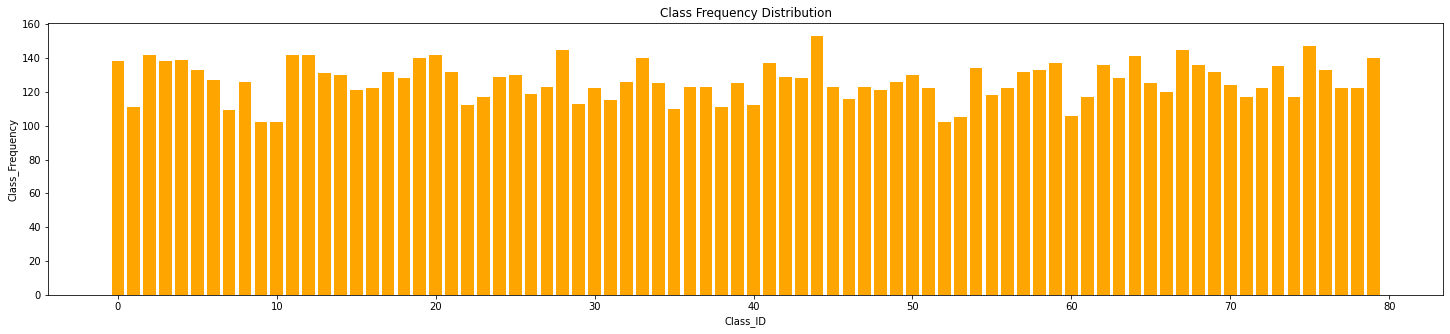

In [43]:
class_ids = list(class_dict.keys())
counts = list(class_dict.values())
fig = plt.figure(figsize = (25, 5))
plt.bar(class_ids, counts, color ='orange')
plt.xlabel("Class_ID")
plt.ylabel("Class_Frequency")
plt.title("Class Frequency Distribution")
plt.show()

Scatter Plot for Normalised Bounding Box Width & Height

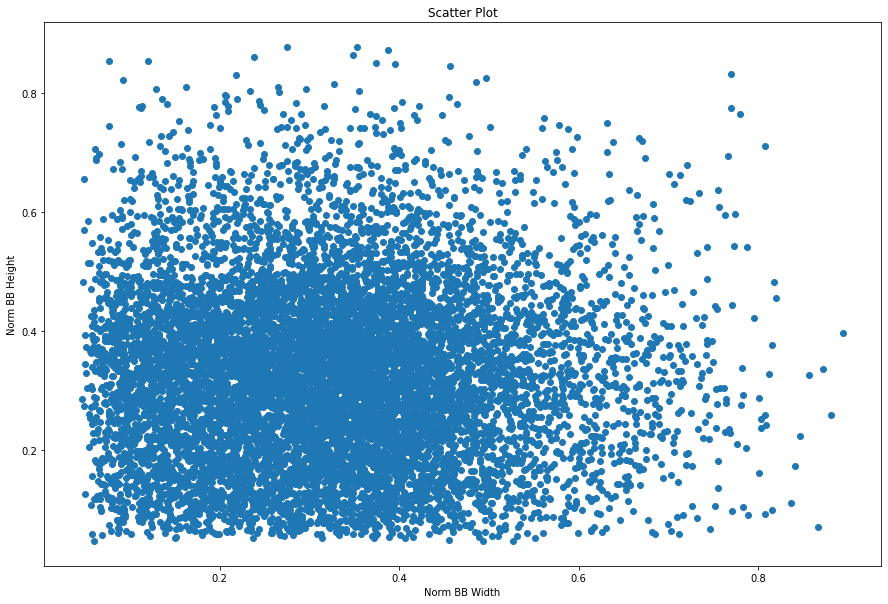

In [46]:
plt.figure(figsize = (15, 10))
plt.scatter(df['norm_bb_w'], df['norm_bb_h'])
plt.xlabel('Norm BB Width')
plt.ylabel('Norm BB Height')
plt.title('Scatter Plot Norm')
plt.show()

Scatter Plot for Log Normalised Bounding Box Width & Height

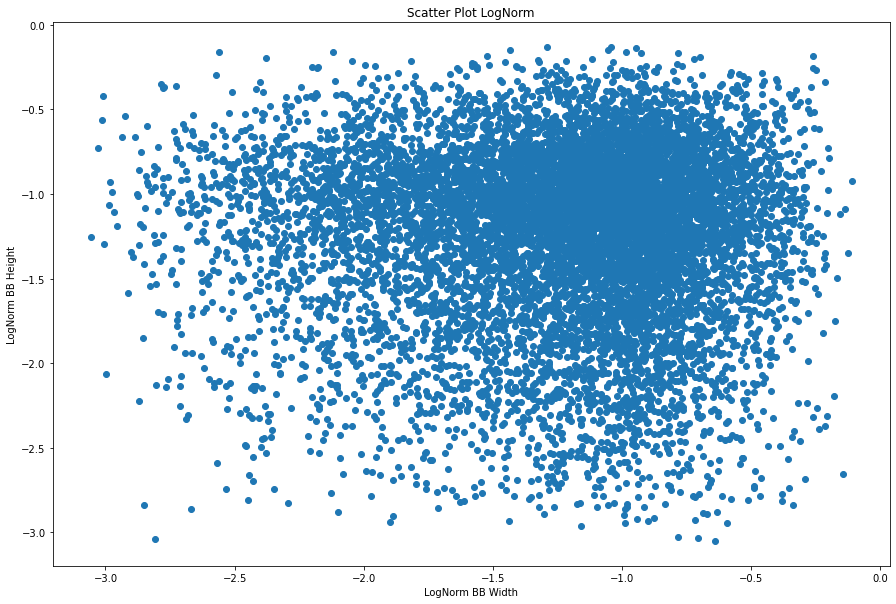

In [50]:
plt.figure(figsize = (15, 10))
plt.scatter(df['log_norm_bb_w'], df['log_norm_bb_h'])
plt.xlabel('LogNorm BB Width')
plt.ylabel('LogNorm BB Height')
plt.title('Scatter Plot LogNorm')
plt.show()

In [56]:
X = df[['log_norm_bb_w', 'log_norm_bb_h']].to_numpy()

In [67]:
wcss = []  # Within-Cluster Sum of Square -> sum of squared distance between each point and the centroid in a cluster.

'''
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as
the inertia or within-cluster sum-of-squares.
Here we are trying out n=1 to 10 clusters to figure out which one is best
'''

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

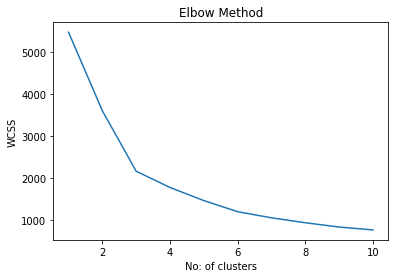

In [68]:
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('No: of clusters')
plt.ylabel('WCSS')
plt.show()

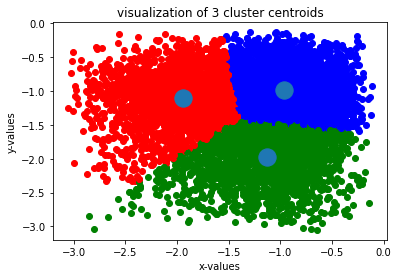

In [60]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
colors=['red', 'green', 'blue', 'orange', 'yellow']
pred_y = kmeans.fit_predict(X)
for i in range(len(pred_y)):
    plt.scatter(X[i,0],X[i,1],c=colors[pred_y[i]])
    plt.title('visualization of 3 cluster centroids')
    plt.xlabel('x-values')
    plt.ylabel('y-values')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300)
plt.show()

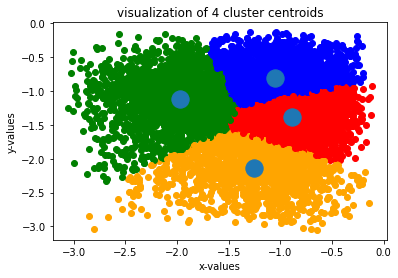

In [59]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
colors=['red', 'green', 'blue', 'orange', 'yellow']
pred_y = kmeans.fit_predict(X)
for i in range(len(pred_y)):
    plt.scatter(X[i,0],X[i,1],c=colors[pred_y[i]])
    plt.title('visualization of 4 cluster centroids')
    plt.xlabel('x-values')
    plt.ylabel('y-values')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300)
plt.show()

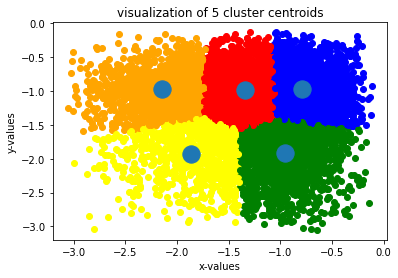

In [61]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
colors=['red', 'green', 'blue', 'orange', 'yellow']
pred_y = kmeans.fit_predict(X)
for i in range(len(pred_y)):
    plt.scatter(X[i,0],X[i,1],c=colors[pred_y[i]])
    plt.title('visualization of 5 cluster centroids')
    plt.xlabel('x-values')
    plt.ylabel('y-values')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300)
plt.show()

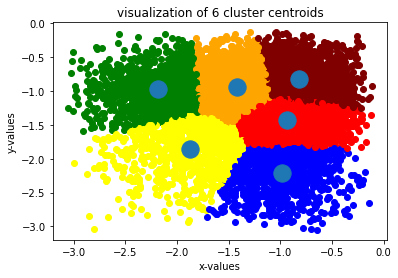

In [62]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
colors=['red', 'green', 'blue', 'orange', 'yellow', 'maroon']
pred_y = kmeans.fit_predict(X)
for i in range(len(pred_y)):
    plt.scatter(X[i,0],X[i,1],c=colors[pred_y[i]])
    plt.title('visualization of 6 cluster centroids')
    plt.xlabel('x-values')
    plt.ylabel('y-values')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300)
plt.show()

AnchorBox: 3 clusters  

[[0.21809509 0.23929299]
 [0.47835678 0.2747299 ]
 [0.29331977 0.48987749]] 

AnchorBox: 4 clusters  

[[0.48097651 0.27242445]
 [0.20521189 0.38892584]
 [0.24723759 0.181607  ]
 [0.38518939 0.532798  ]] 

AnchorBox: 5 clusters  

[[0.38878867 0.23389329]
 [0.20236762 0.38897618]
 [0.19032635 0.18305025]
 [0.35055855 0.53643849]
 [0.57819562 0.33879416]] 

AnchorBox: 6 clusters  

[[0.58712601 0.34423637]
 [0.17028603 0.40289645]
 [0.19043947 0.19244825]
 [0.40450835 0.17267557]
 [0.35579082 0.35962025]
 [0.33591888 0.59183117]] 



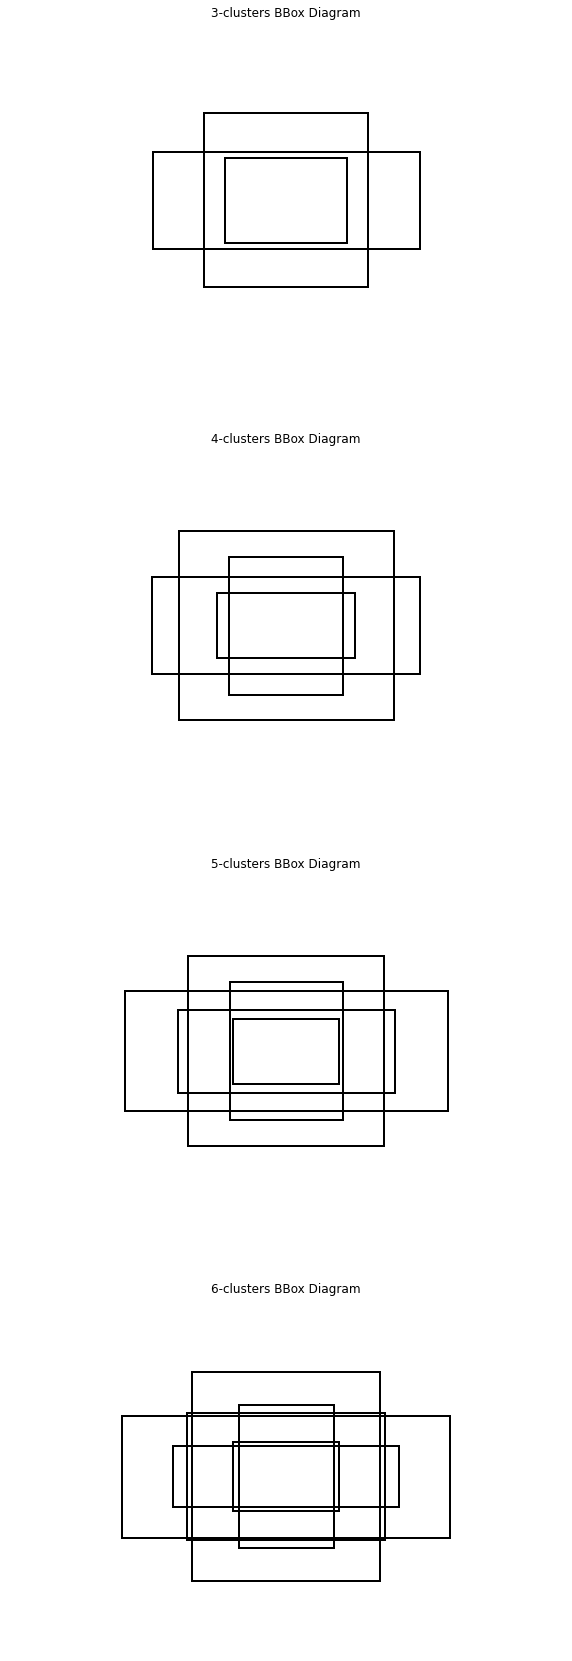

In [83]:
wcss = []
x = df[['norm_bb_w', 'norm_bb_h']]

fig, axes = plt.subplots(4,1,figsize= (10, 30))
id = 0
for n_clusters in range(3, 7):

    ax = axes[id]
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(x)

    print("AnchorBox: {} clusters  \n".format(n_clusters))
    print(kmeans.cluster_centers_,'\n')

    anchors_ = kmeans.cluster_centers_
    anchors = anchors_

    ax.set_title('{}-clusters BBox Diagram'.format(n_clusters))
    ax.axis('off')
    for i in range(0, n_clusters):
        ax.add_patch(Rectangle((-1*anchors[i][0]/2 + 0.5, -1*anchors[i][1]/2 + 0.5), anchors[i][0], anchors[i][1], fill=False, linewidth=2))
    id = id + 1

plt.show()